# Notebook 3. Fit Clustering

This notebook fits different clustering methods and selects the most reasonable among them.

In [1]:
from typing import Any
from typing import List
from typing import Union
from typing import Tuple

import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib

LINE_WIDTH_THICK: float = 10.
LINE_WIDTH_THIN: float = 2.5
N_MONTHS_IN_YEAR: int = 12
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THICK

%matplotlib inline
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)

import dtaidistance
from dtaidistance import dtw
from dtaidistance import clustering
from matplotlib.pyplot import figure

# 0. Reading and preparing the data.

In [2]:
class DataTable: pass
all_table: DataTable = joblib.load("prepared_data/all_data_with_na.jbl")
if not os.path.exists("images/clustering/"):
    os.makedirs("images/clustering/")
if not os.path.exists("algorithms"):
    os.makedirs("algorithms")

In [3]:
def prepare_tslearn_dataset(all_table: DataTable) -> Union[np.array, List[List[List[float]]]]:
    """ Prepares dataset for using in TSLearn. It requers specific storage
    format, and only contracts that are already complete. Of them, first 12 
    entries are used.
    
    Arguments:
        all_table:  All data as dumped in the previous phase.
    
    Returns:
        Numpy array ready to be used in TSLearn.
    """
    all_table.matrix = copy.deepcopy(all_table.matrix).dropna(axis=0, how='any')
    info: Tuple[Union[List[str], np.array], Union[List[int], np.array]] = np.unique(
        all_table.matrix.CONTRACT_ID, return_counts=True)
    contracts: Union[List[str], np.array] = info[0]
    amounts: Union[List[int], np.array] = info[1]

    N_MONTHS: int = 12
    
    relevant: List[str] = list()
    contract_id: str; amount: int
    for contract_id, amount in zip(contracts, amounts):
        if amount >= N_MONTHS:
            relevant.append(contract_id)
    matrix: pd.DataFrame = all_table.matrix
    long_enough: pd.DataFrame = matrix[matrix['CONTRACT_ID'].isin(relevant)]
    long_enough = long_enough[long_enough['PERIOD_ID'] <= N_MONTHS]
    series_to_cluster: pd.DataFrame = long_enough[['CONTRACT_ID', 'PERCENT_ACTUAL']]
    X_train: Union[np.array, List[List[List[float]]]] = np.zeros(
        shape=(len(relevant), N_MONTHS, 1), dtype=np.float32)
    
    index: int = 0
    df: pd.DataFrame
    for _, df in series_to_cluster.groupby('CONTRACT_ID'):
        series: pd.Series = df['PERCENT_ACTUAL']
        X_train[index, :, 0] = series
        index += 1
    return X_train

In [4]:
X_train: Union[np.array, List[List[List[float]]]] = prepare_tslearn_dataset(all_table)
DTAI_train: Union[np.array, List[List[float]]] = np.array(X_train.reshape((-1, N_MONTHS_IN_YEAR))).astype(np.float64)

SAMPLE_COUNT: int = 20
DTAI_sample: Union[np.array, List[List[float]]] = DTAI_train[
    np.random.choice(DTAI_train.shape[0], SAMPLE_COUNT, replace=False)]


# 1. Agglomerative Clustering

Agglomerative clustering is typically used to guess the number of clusters.

## 1.1. Hierarchical Tree

First fit on the full dataset, then make dendrogram for a subsample. Essentially, visualization allows to make a guess on 3-5 number of clusters. There is either flat repayments, or single spike, or big initially then flat, or flat and big in the end. 

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 97%|████████████████████████████████████████████████████████████████████████████▊  | 844/868 [00:01<00:00, 478.66it/s]DTAIDistance C-extension for Numpy is not available. Proceeding anyway.

 95%|████████████████████████████████████████████████████████████████████████████    | 19/20 [00:00<00:00, 3850.59it/s]


(None, array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

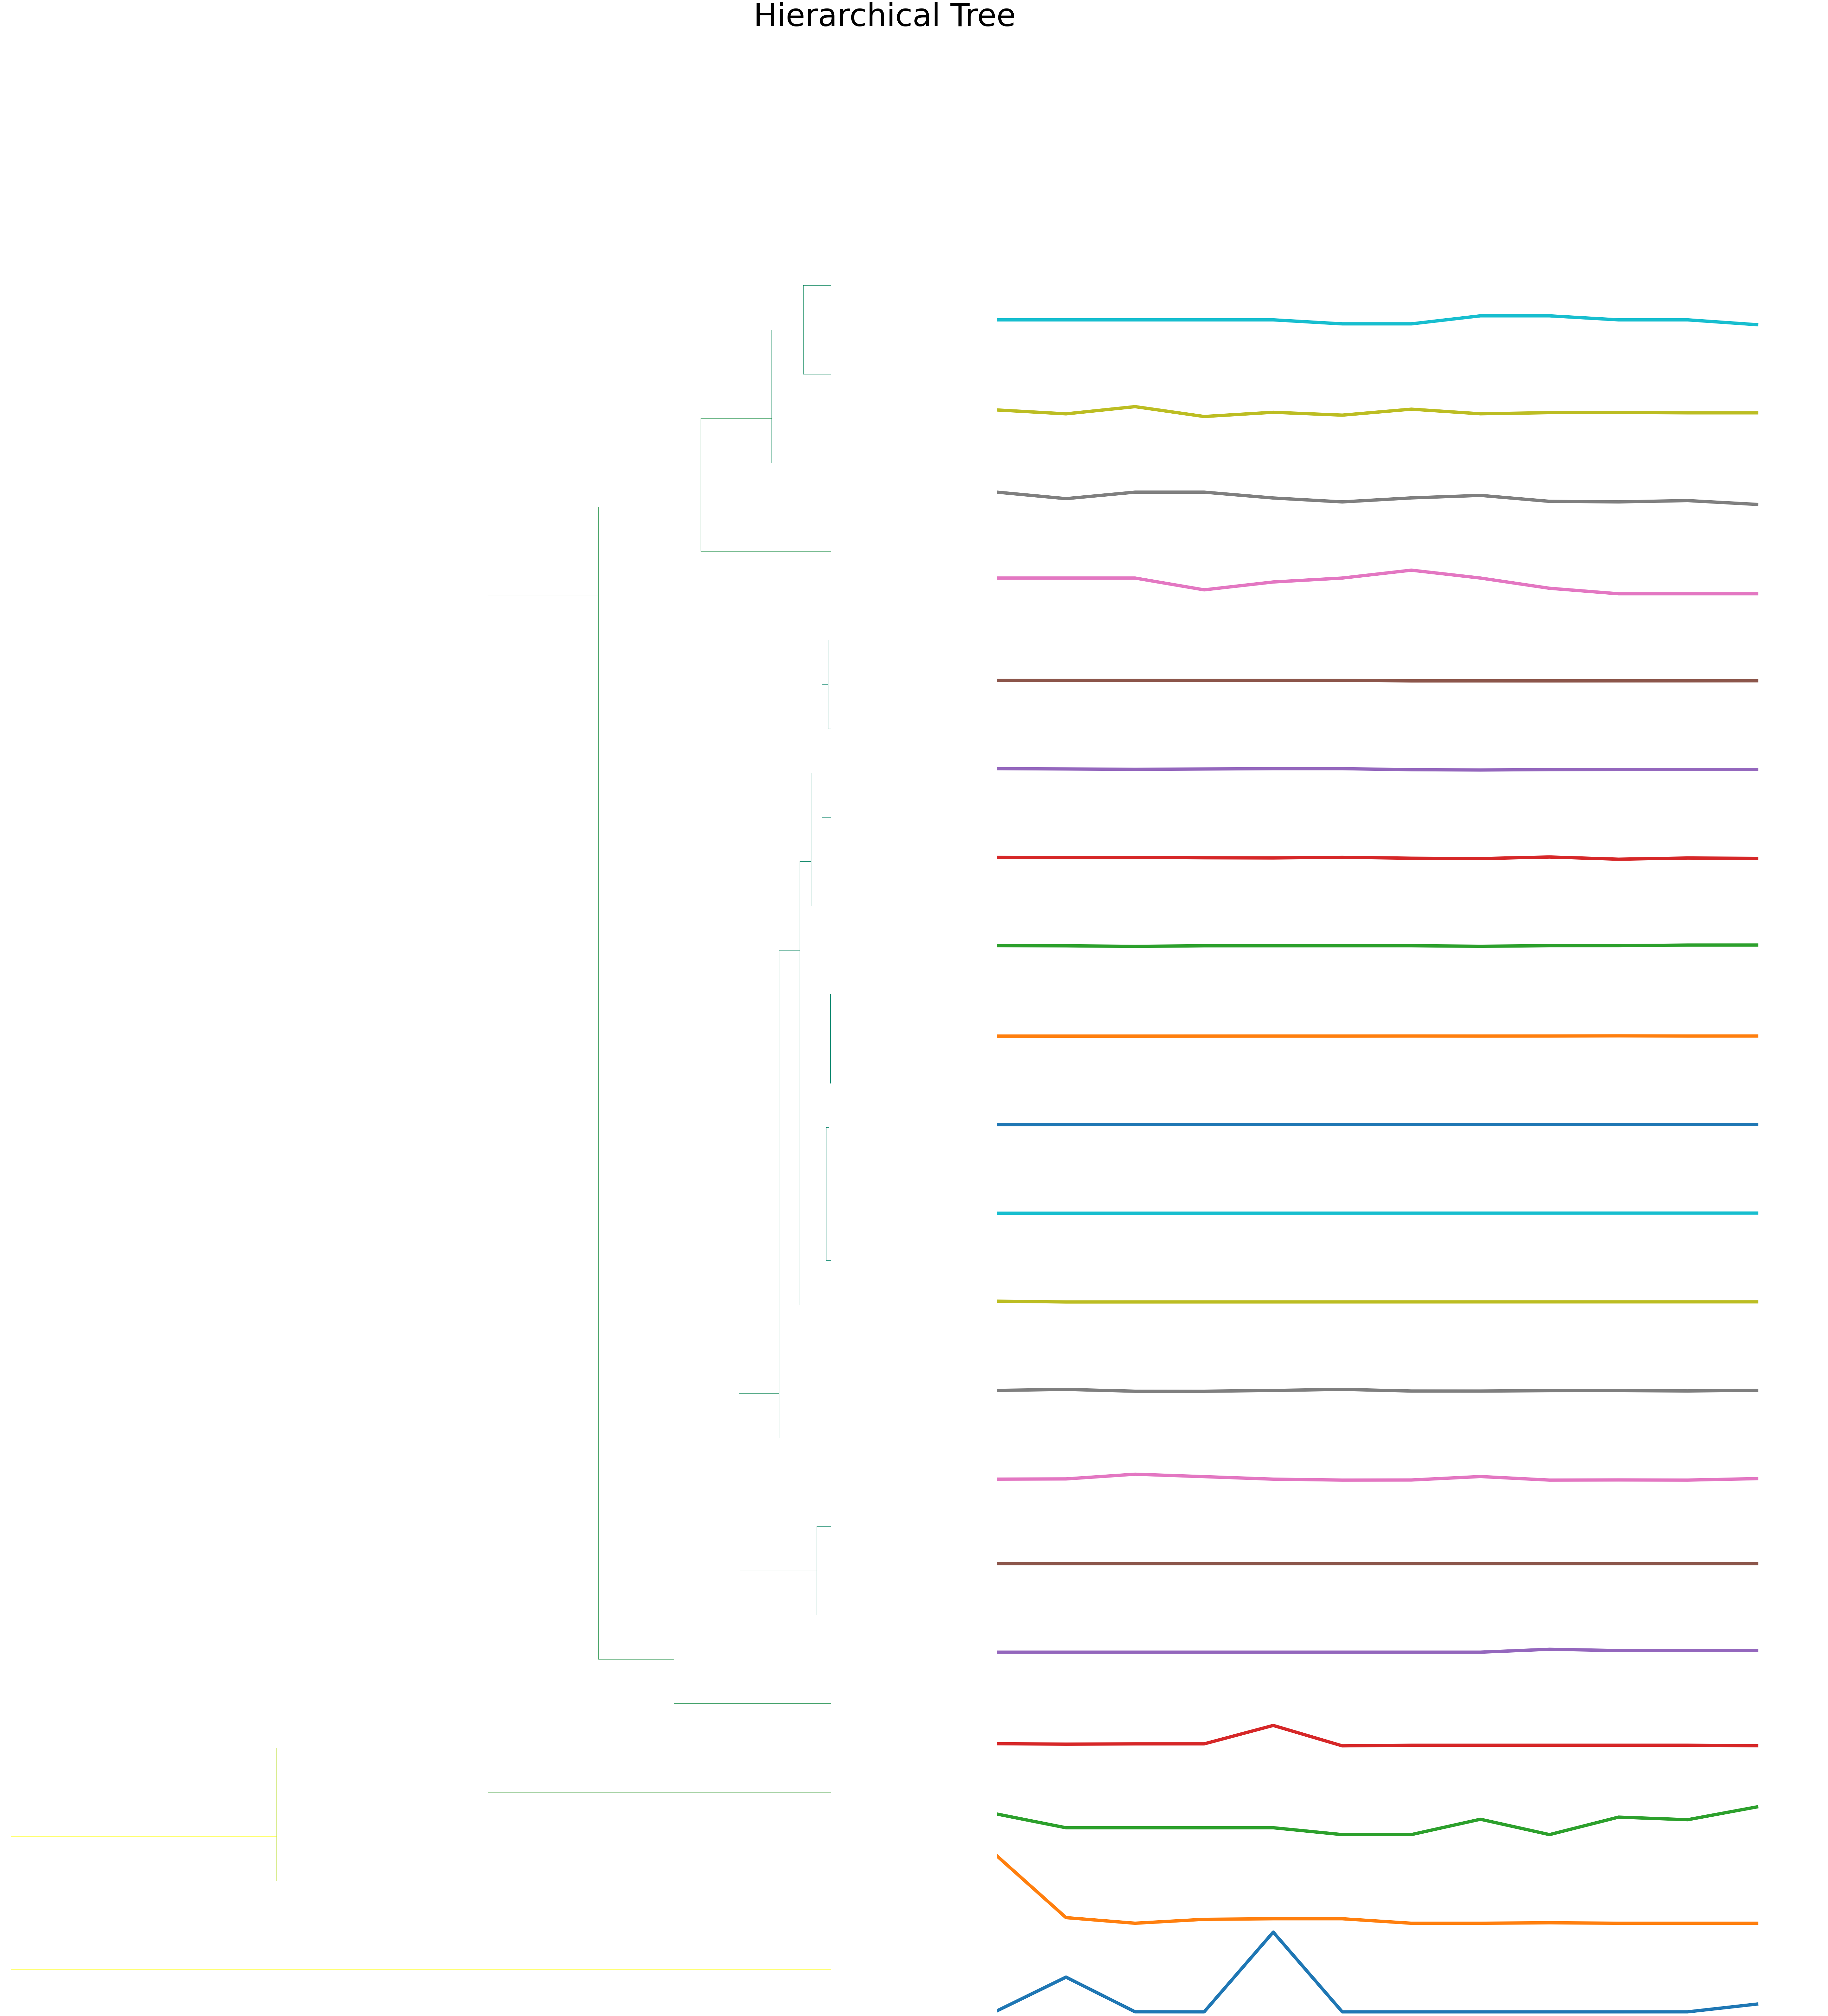

In [5]:
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THICK

cluster_idx: List[int]
hierarchical_model: clustering.Hierarchical = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = hierarchical_model.fit(DTAI_train)

hierarchical_tree: clustering.HierarchicalTree = clustering.HierarchicalTree(hierarchical_model)
cluster_idx = hierarchical_tree.fit(DTAI_sample)

fig: plt.Figure; ax: plt.Axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Hierarchical Tree", fontsize=96)
hierarchical_tree.plot("images/clustering/hierarchical_tree.png", axes=ax, ts_height=100, cmap='summer')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Hierarchical Tree", fontsize=96)
hierarchical_tree.plot(axes=ax, ts_height=100, cmap='summer')

## 1.2. Linkage Tree

After fitting the linkage tree, hypothesis stays the same.

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.


(None, array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

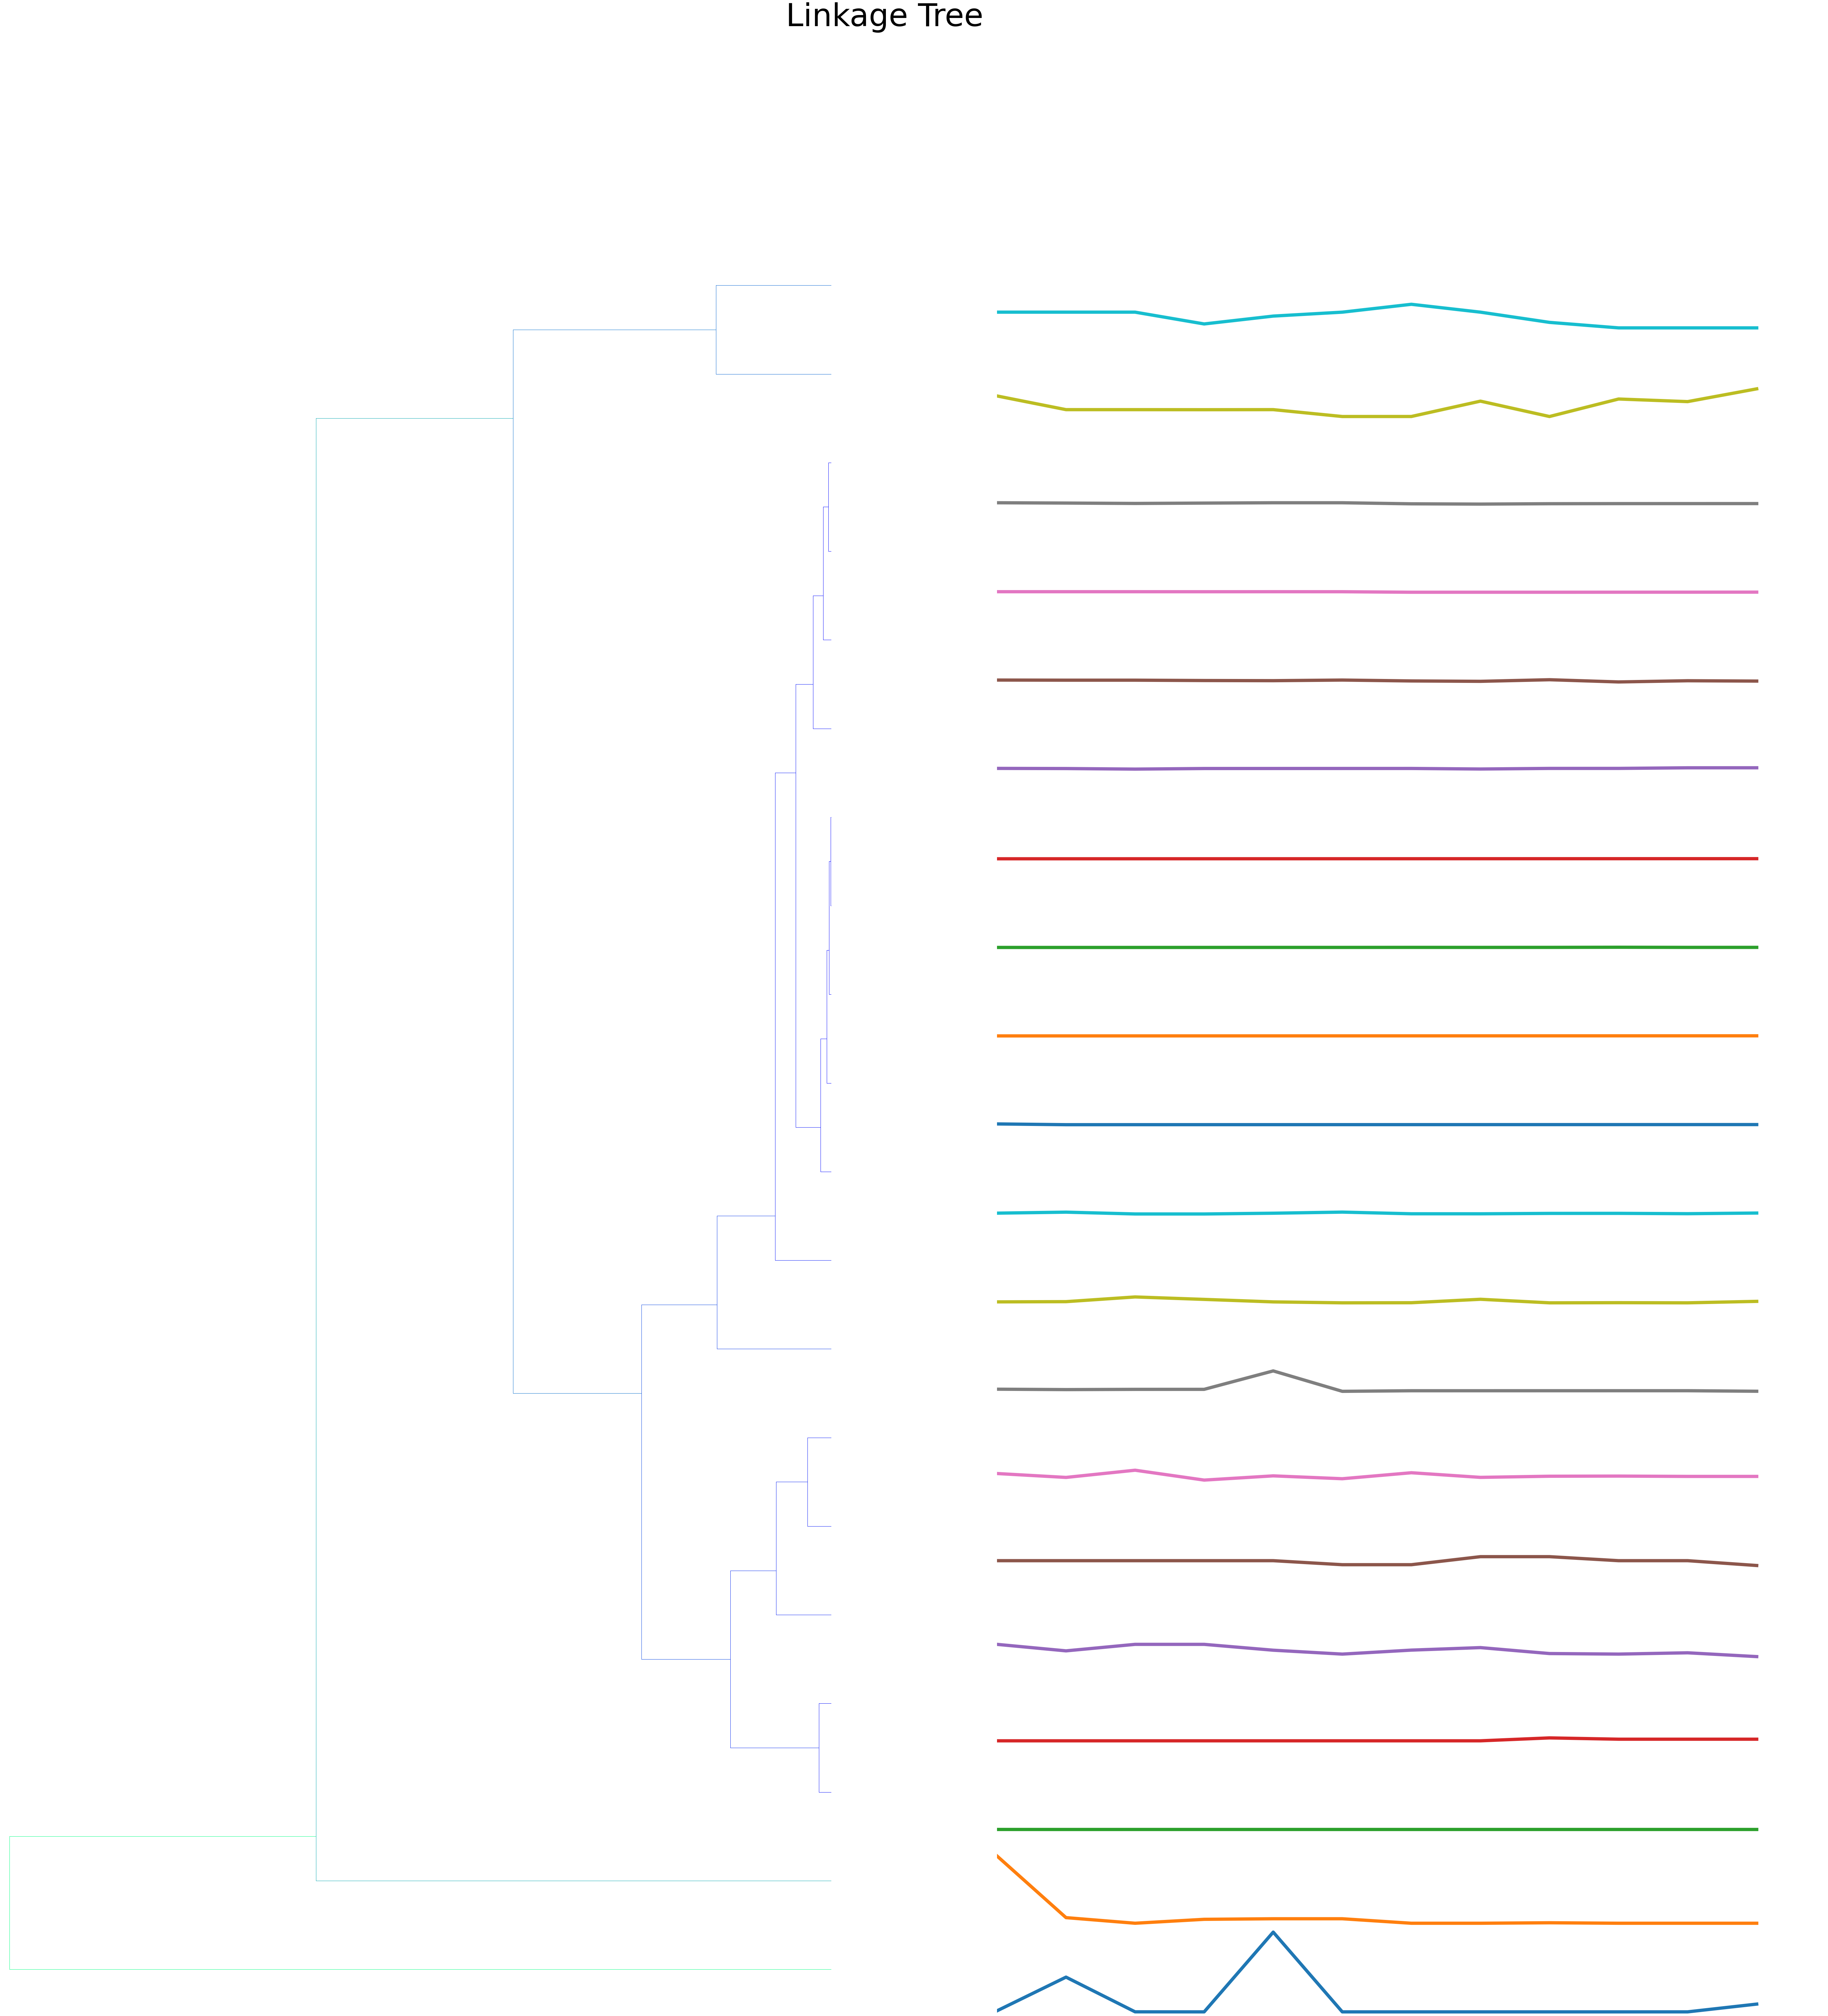

In [6]:
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THICK
linkage_tree: clustering.LinkageTree = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = linkage_tree.fit(DTAI_sample)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Linkage Tree", fontsize=96)
linkage_tree.plot("images/clustering/linkage_tree.png", axes=ax, ts_height=100, cmap='winter')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Linkage Tree", fontsize=96)
linkage_tree.plot(axes=ax, ts_height=100, cmap='winter')

## 1.3. k-Medoids

k-Medoids find three types of clusters: gradually decreasing, flat repayment ans spiked repayment.

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.


(None, array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

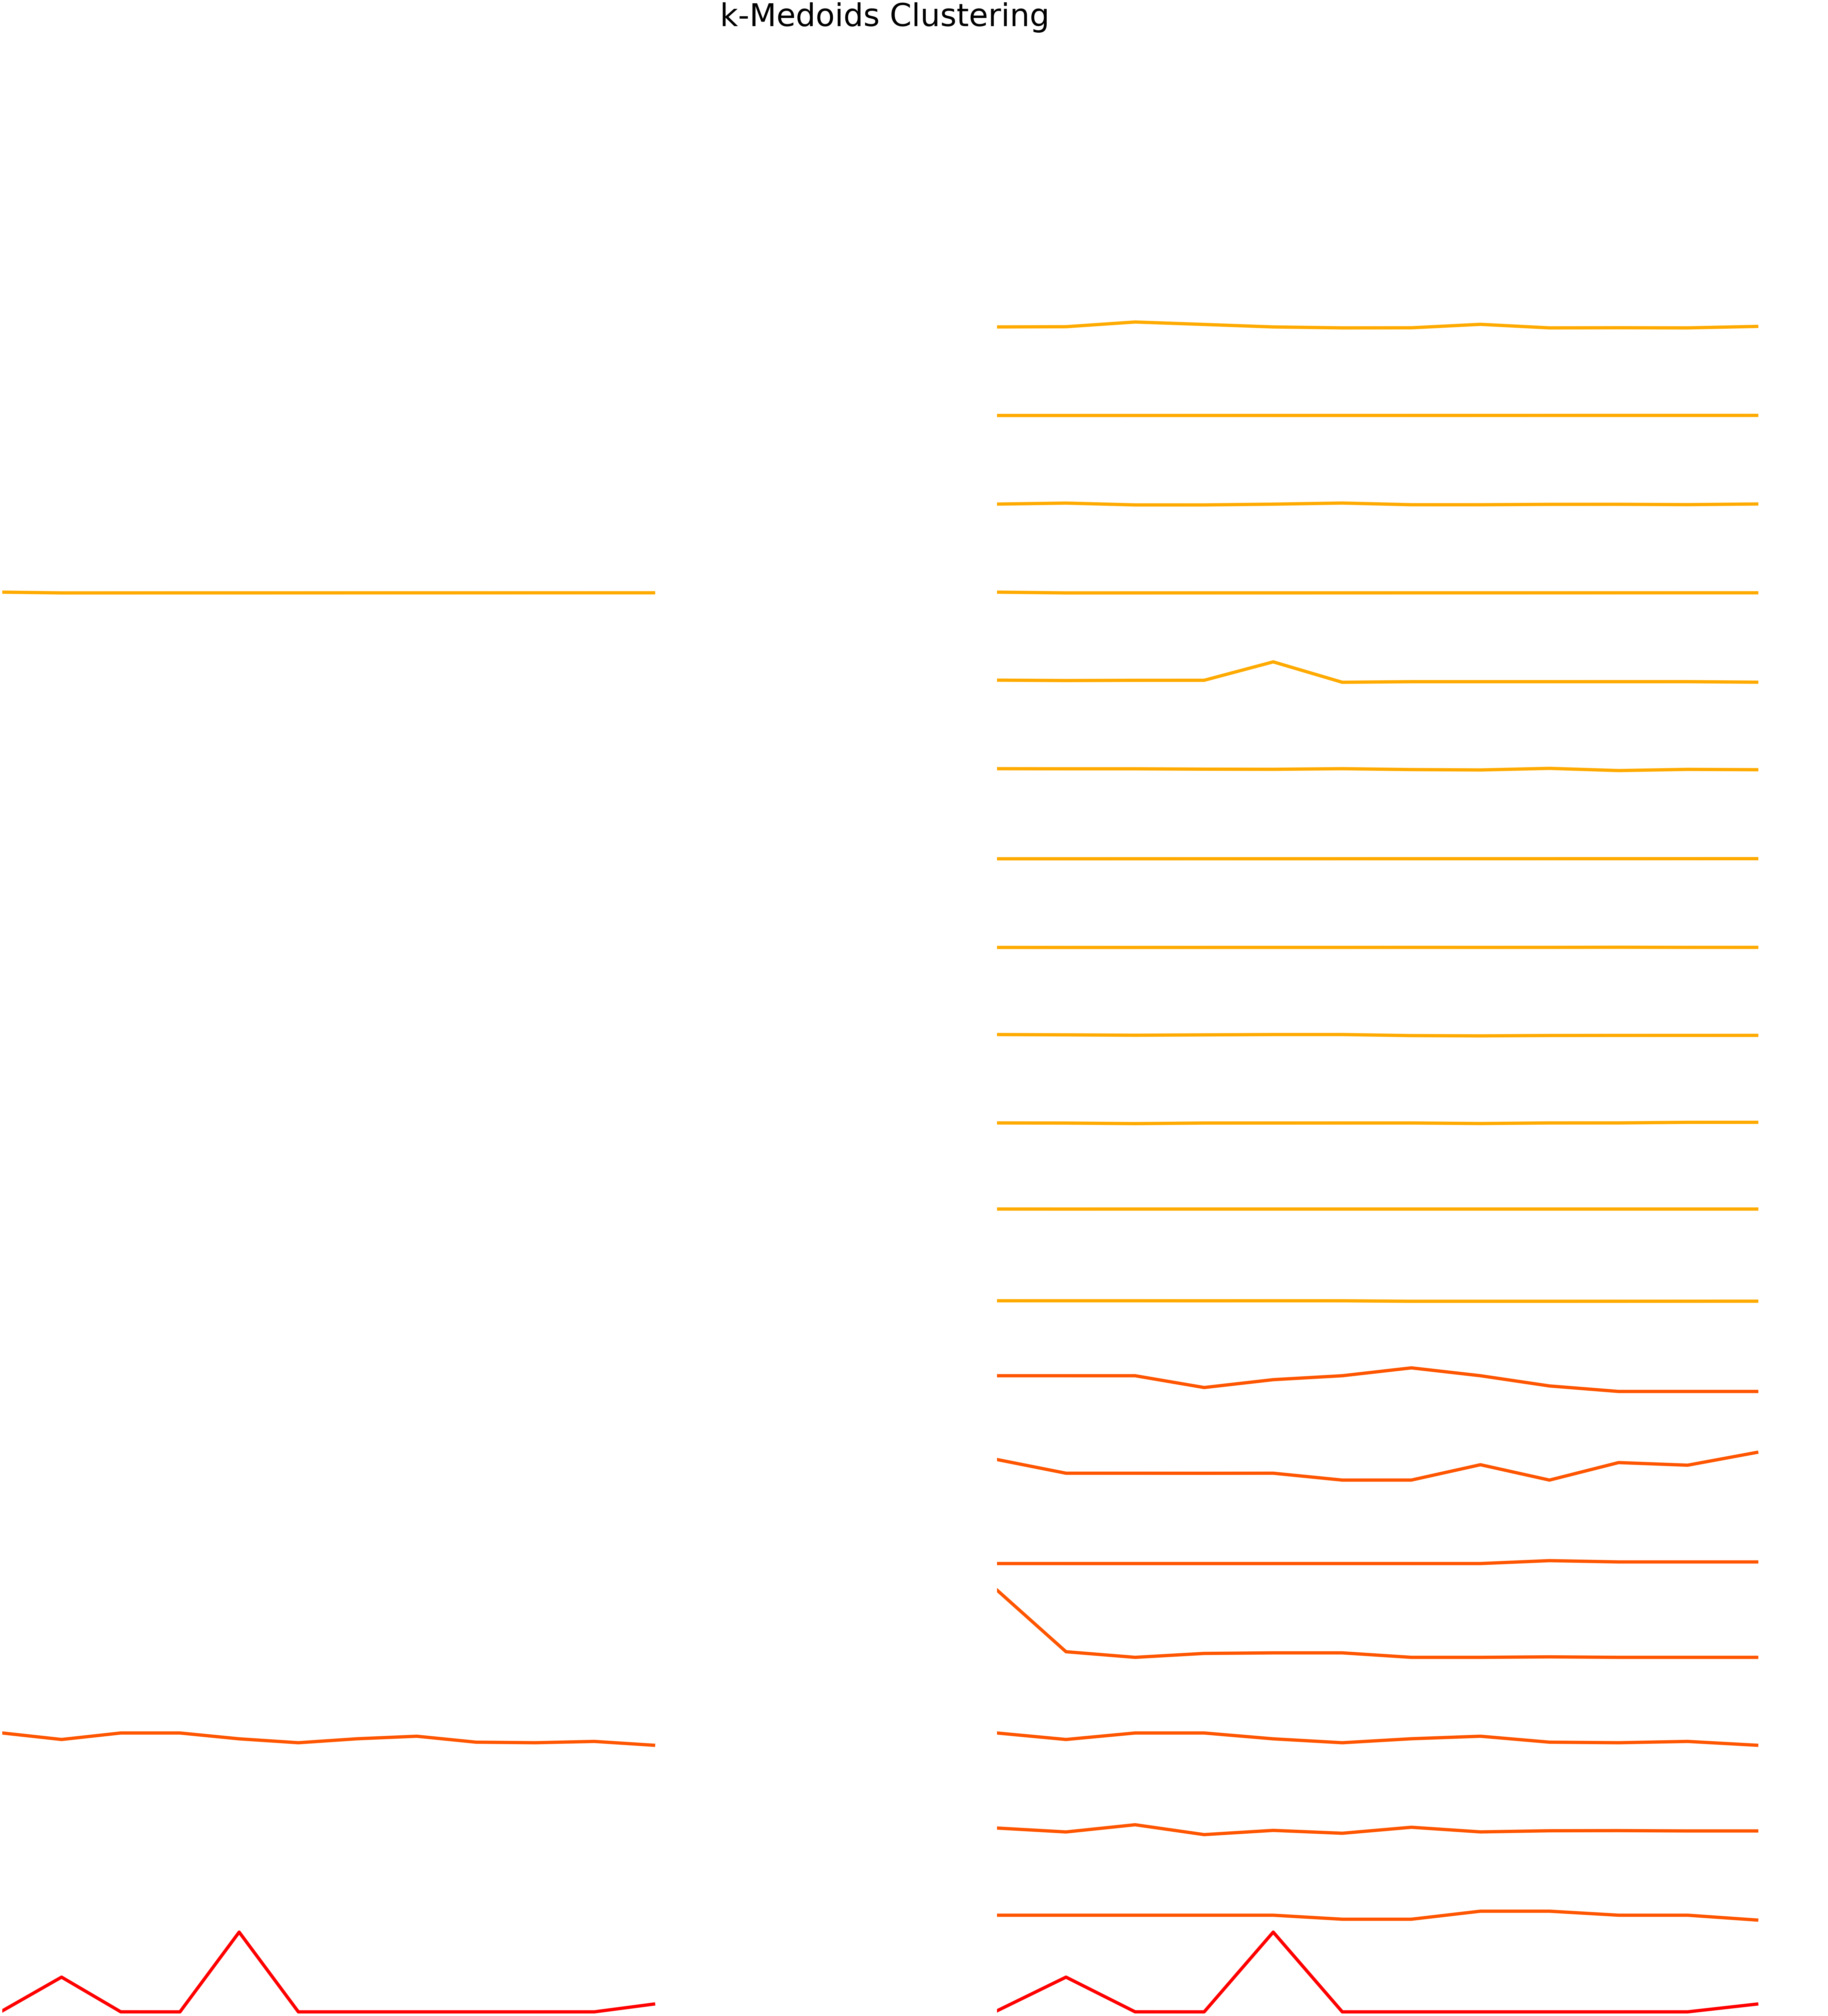

In [7]:
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THICK
N_MEDOIDS: int = 3
medoids: clustering.KMedoids = clustering.KMedoids(dtw.distance_matrix_fast, dict(), k=N_MEDOIDS)
cluster_idx = medoids.fit(DTAI_sample)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("k-Medoids Clustering", fontsize=96)
medoids.plot('images/clustering/kmedoids.png', axes=ax, ts_height=100, cmap='autumn')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("k-Medoids Clustering", fontsize=96)
medoids.plot(axes=ax, ts_height=100, cmap='autumn')

# 2. Tslearn Clustering


In [8]:
from tslearn.barycenters import dtw_barycenter_averaging

def visualize_clustering(X_train: pd.DataFrame, title: str, algorithm: Any, 
                         labels: Union[List[int], np.array], 
                         n_clusters: int, filename: str) -> None:
    """ Visualizes Tslearn clustering and saves figure to the path described in filename.
    
    Arguments:
        X_train -- Dataframe with training data.
        title -- Title of the image.
        algorithm -- Algorithm object from Tslearn. Possible values: TimeSeriesKMeans, KShape, KernelKMeans.
        labels -- Array with cluster labels.
        n_clusters -- Number of clusters.
        filename -- Path of the file to save the image.
    """
    YEAR_SIZE: int = 12
    plt.figure(figsize=(20,10))
    fig: plt.Figure = plt.gcf()
    fig.suptitle(title, fontsize=14)
    
    y_idx: int
    for y_idx in range(n_clusters):
        plt.subplot(n_clusters, 1, y_idx + 1)
        
        cluster_data: np.array
        for cluster_data in X_train[y_pred == y_idx]:
            plt.plot(list(range(1, YEAR_SIZE + 1)), cluster_data.ravel(), "k-", alpha=.2)
            
        # If cluster centers are specified by the algorithm, plot them.
        # Otherwise, make them with dtw_barycenter_averaging and plot the result.
        if hasattr(algorithm, 'cluster_centers_'):
            plt.plot(list(range(1, YEAR_SIZE + 1)), algorithm.cluster_centers_[y_idx].ravel(), "r-")
        else:
            barycenter: np.array = dtw_barycenter_averaging(X_train[y_pred==y_idx], max_iter=50, tol=1e-3)
            plt.plot(list(range(1, YEAR_SIZE + 1)), barycenter.ravel(), "r-")
        plt.xlim(1, YEAR_SIZE)
        
    plt.savefig(filename, dpi=300, bbox_inches='tight')

In [9]:
def print_clustering_report(clusters: Union[np.array, List[int]]) -> None:
    """ Prints clustering report.
    
    Arguments:
        clusters: Array with cluster labels.
    """
    info: Tuple[Union[np.array, List[int]], Union[np.array, List[int]]] = np.unique(clusters, return_counts=True)
    
    idx: int; count: int
    for idx, count in zip(info[0], info[1]):
        print("Cluster:", idx + 1, "Size:", count)


In [10]:
def make_clustering_barplot(clusters: Union[np.array, List[int]], 
                            title: str, save_path: str) -> None:
    """ Creates clustering barplot and saves to a file.
    
    Arguments:
        clusters: Array with cluster labels.
        title: Title of the plot.
        save_path: Path to save the image.
    """
    info: Tuple[Union[np.array, List[int]], 
                Union[np.array, List[int]]] = np.unique(clusters, return_counts=True)
    cluster_df: pd.DataFrame = pd.DataFrame()
    cluster_df['Clusters'] = info[0] + 1
    cluster_df['Sizes'] = info[1]
    sns.barplot('Clusters', 'Sizes', data=cluster_df)
    plt.title(title)
    plt.savefig(save_path)

## 2.1. DTW clustering

By hand-based tuning, four patterns look the most realistic:
- Flat repayment
- Spiked repayment (flat, then fixing almost all dept, and then flatly concluding)
- Flat and high payment at the end.
- High payment initially and flat repayment to the end.

In [11]:
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THIN
from tslearn.clustering import TimeSeriesKMeans

N_CLUSTERS_DTW: int = 4
dtw_km: TimeSeriesKMeans = TimeSeriesKMeans(n_clusters=N_CLUSTERS_DTW, n_init=3, 
                                            metric="dtw", verbose=False,
                                            n_jobs=-1, max_iter_barycenter=10, random_state=42)
y_pred: Union[np.array, List[int]] = dtw_km.fit_predict(X_train)
joblib.dump(dtw_km, 'algorithms/dtw_km.alg')

C:\Users\nekrald\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


['algorithms/dtw_km.alg']

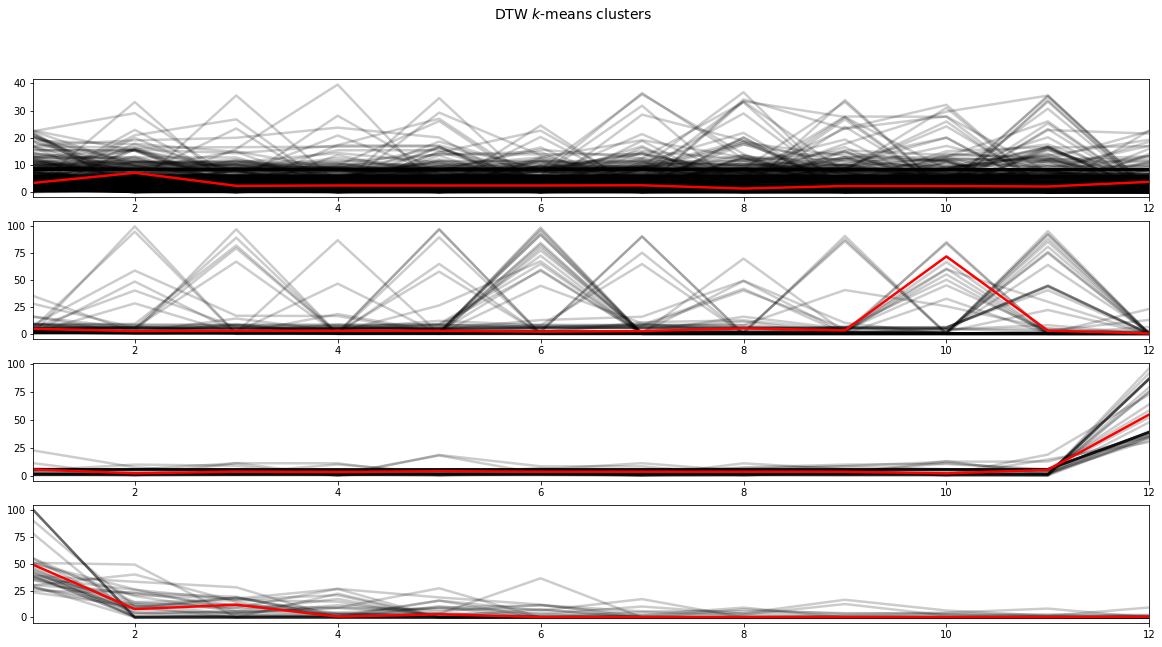

In [12]:
visualize_clustering(X_train, "DTW $k$-means clusters", dtw_km, y_pred, 
                     N_CLUSTERS_DTW, 'images/clustering/dtw_k_means_clusters.png')

Cluster: 1 Size: 734
Cluster: 2 Size: 67
Cluster: 3 Size: 36
Cluster: 4 Size: 31


C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


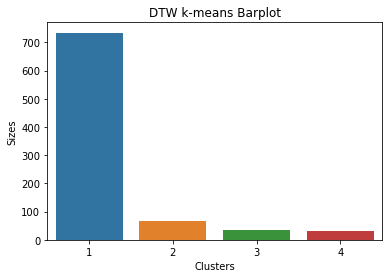

In [13]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "DTW k-means Barplot", 'images/clustering/dtw_kmeans_barplot.png')

## 2.2. KShape clustering

kShape clusters does not look very effective, though spiked pattern is also present.

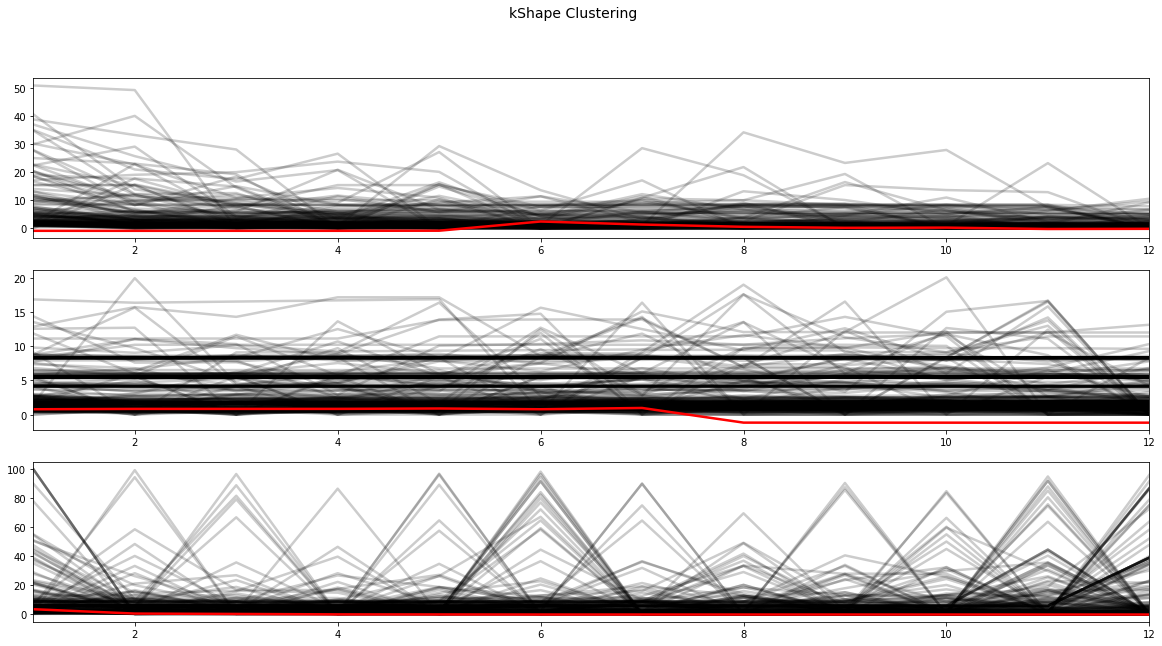

In [14]:
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THIN
from tslearn.clustering import KShape
N_CLUSTERS_KSHAPE: int = 3
ks: KShape = KShape(n_clusters=N_CLUSTERS_KSHAPE, verbose=False, random_state=42, n_init=15, tol=1e-7, max_iter=200)
y_pred = ks.fit_predict(X_train)
visualize_clustering(X_train, "kShape Clustering", ks, y_pred, 
                     N_CLUSTERS_KSHAPE, "images/clustering/kshape_clusters.png")

Cluster: 1 Size: 166
Cluster: 2 Size: 450
Cluster: 3 Size: 252


C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


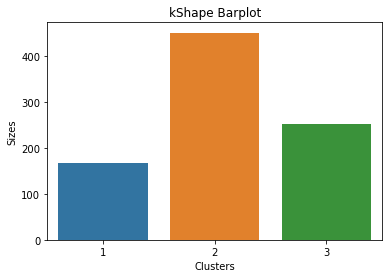

In [15]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "kShape Barplot", 'images/clustering/kshape_barplot.png')

## 2.3. Kernel kMeans

Kernel kMeans have found spiked pattern, big initially then flat, and flat then big in the end.

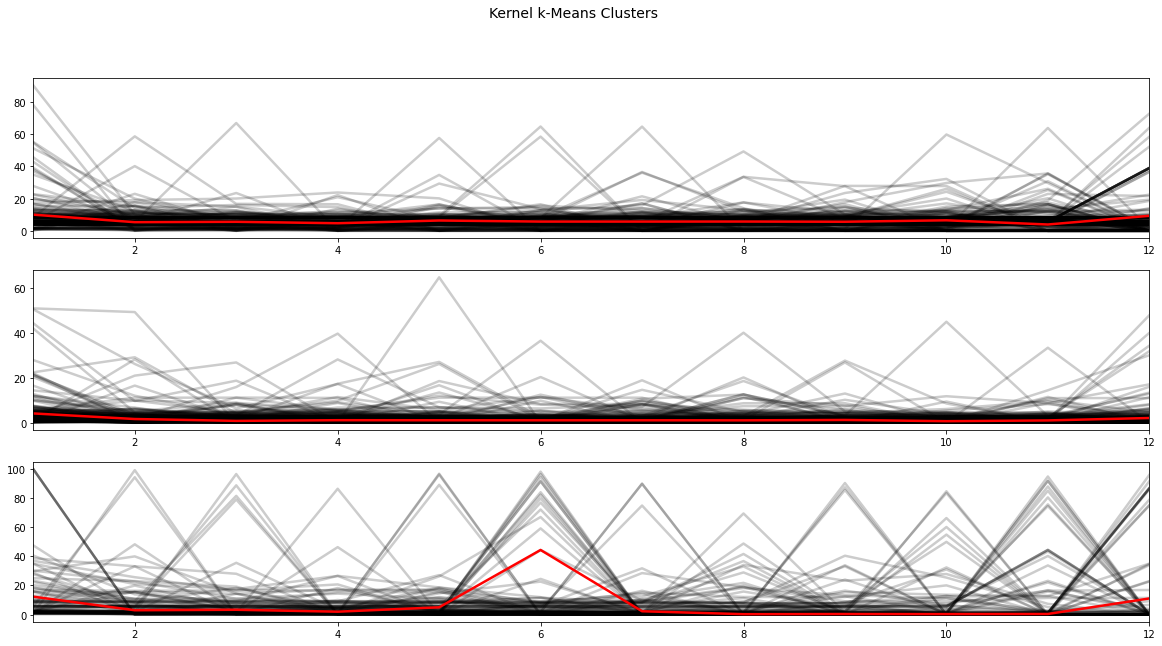

In [16]:
from tslearn.clustering import KernelKMeans
matplotlib.rcParams['lines.linewidth'] = LINE_WIDTH_THIN

N_CLUSTERS_KKM: int = 3
gak_km: KernelKMeans = KernelKMeans(n_clusters=N_CLUSTERS_KKM, kernel="gak", kernel_params={"sigma": "auto"},
                      n_init=5, verbose=False, n_jobs=-1, random_state=42)
y_pred = gak_km.fit_predict(X_train)
visualize_clustering(X_train, "Kernel k-Means Clusters", gak_km, y_pred, 
                     N_CLUSTERS_KKM, "images/clustering/kernel_kmeans_clusters.png")

Cluster: 1 Size: 274
Cluster: 2 Size: 485
Cluster: 3 Size: 109


C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


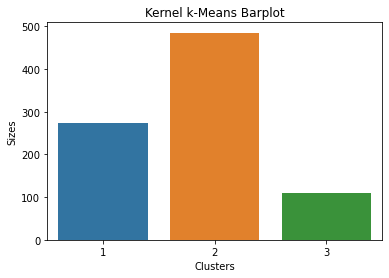

In [17]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "Kernel k-Means Barplot", 'images/clustering/kernel_kmeans_barplot.png')